In [1]:
# !pip install pandas matplotlib seaborn scikit-learn transformers datasets

In [2]:
# pip install plotnine

In [3]:
# !pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer, BertModel
from datasets import Dataset
from plotnine import *
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from tqdm.notebook import tqdm

In [5]:
ls

config_windows.npz         scaler_log_return_192.joblib
data_modeling-Copy1.ipynb  scaler_log_return.joblib
data_modeling.ipynb        vanilla_transformer.ipynb
during_pre_post.csv        vanilla_transformer_spx.pt


In [6]:
# mv ../data/during_pre_post\ copy.csv ../data/during_pre_post.csv

In [7]:
df = pd.read_csv('/home/fti_ncchethala/timeseries_forecastin_llms/src/during_pre_post.csv')

In [8]:
df.head()

,tickerdate,tickertime,index_symbol,market_phase,open,high,low,close
0,2007-10-26,11:59:00,SPX,GFC_Crash,1523.00,1523.00,1521.97,1521.97
1,2007-11-02,12:47:00,SPX,GFC_Crash,1508.00,1508.50,1508.00,1508.46
2,2007-11-21,15:37:00,SPX,GFC_Crash,1425.00,1425.00,1423.97,1424.25
3,2007-12-11,10:37:00,SPX,GFC_Crash,1515.16,1515.16,1515.00,1515.00
4,2008-02-20,15:49:00,SPX,GFC_Crash,1357.00,1357.00,1356.31,1356.61


In [9]:
# Drop column "market_phase"
df = df.drop(columns=["market_phase"])

In [10]:
# separate the dataframe based on "index_symbol"
df_list = [group for _, group in df.groupby("index_symbol")]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060282 entries, 0 to 3060281
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   tickerdate    object 
 1   tickertime    object 
 2   index_symbol  object 
 3   open          float64
 4   high          float64
 5   low           float64
 6   close         float64
dtypes: float64(4), object(3)
memory usage: 163.4+ MB


In [12]:
df.describe()

,open,high,low,close
count,3.060282e+06,3.060282e+06,3.060282e+06,3.060282e+06
mean,3.923410e+03,3.924275e+03,3.922546e+03,3.923412e+03
std,3.402924e+03,3.403852e+03,3.401997e+03,3.402925e+03
min,6.669000e+02,6.670400e+02,6.667900e+02,6.667900e+02
25%,1.792490e+03,1.792780e+03,1.792180e+03,1.792480e+03
50%,2.675310e+03,2.675910e+03,2.674700e+03,2.675290e+03
75%,4.452130e+03,4.452780e+03,4.451450e+03,4.452120e+03
max,1.675732e+04,1.676485e+04,1.675530e+04,1.675812e+04


## Data cleaning

In [13]:
spx_df = df[df['index_symbol'] == 'SPX']
ndx_df = df[df['index_symbol'] == 'NDX']

In [14]:
spx_df.head()

,tickerdate,tickertime,index_symbol,open,high,low,close
0,2007-10-26,11:59:00,SPX,1523.00,1523.00,1521.97,1521.97
1,2007-11-02,12:47:00,SPX,1508.00,1508.50,1508.00,1508.46
2,2007-11-21,15:37:00,SPX,1425.00,1425.00,1423.97,1424.25
3,2007-12-11,10:37:00,SPX,1515.16,1515.16,1515.00,1515.00
4,2008-02-20,15:49:00,SPX,1357.00,1357.00,1356.31,1356.61


In [15]:
spx_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1537664 entries, 0 to 1537663
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   tickerdate    1537664 non-null  object 
 1   tickertime    1537664 non-null  object 
 2   index_symbol  1537664 non-null  object 
 3   open          1537664 non-null  float64
 4   high          1537664 non-null  float64
 5   low           1537664 non-null  float64
 6   close         1537664 non-null  float64
dtypes: float64(4), object(3)
memory usage: 93.9+ MB


In [16]:
spx_df.describe()

,open,high,low,close
count,1.537664e+06,1.537664e+06,1.537664e+06,1.537664e+06
mean,2.239674e+03,2.240077e+03,2.239270e+03,2.239674e+03
std,1.038059e+03,1.038293e+03,1.037823e+03,1.038059e+03
min,6.669000e+02,6.670400e+02,6.667900e+02,6.667900e+02
25%,1.343180e+03,1.343370e+03,1.343000e+03,1.343180e+03
50%,2.051210e+03,2.051460e+03,2.050920e+03,2.051190e+03
75%,2.866733e+03,2.867240e+03,2.866270e+03,2.866753e+03
max,4.817770e+03,4.818620e+03,4.816450e+03,4.817670e+03


In [17]:
ndx_df.head()

,tickerdate,tickertime,index_symbol,open,high,low,close
1537664,2007-10-12,15:32:00,NDX,2168.00,2168.00,2166.65,2166.65
1537665,2007-12-24,09:58:00,NDX,2122.00,2122.56,2122.00,2122.56
1537666,2007-12-27,14:43:00,NDX,2118.00,2118.00,2117.31,2117.31
1537667,2008-01-02,14:45:00,NDX,2050.74,2052.00,2050.74,2052.00
1537668,2008-01-16,11:52:00,NDX,1874.00,1876.13,1874.00,1875.76


In [18]:
ndx_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1522618 entries, 1537664 to 3060281
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   tickerdate    1522618 non-null  object 
 1   tickertime    1522618 non-null  object 
 2   index_symbol  1522618 non-null  object 
 3   open          1522618 non-null  float64
 4   high          1522618 non-null  float64
 5   low           1522618 non-null  float64
 6   close         1522618 non-null  float64
dtypes: float64(4), object(3)
memory usage: 92.9+ MB


In [19]:
ndx_df.describe()

,open,high,low,close
count,1.522618e+06,1.522618e+06,1.522618e+06,1.522618e+06
mean,5.623784e+03,5.625115e+03,5.622455e+03,5.623787e+03
std,4.053609e+03,4.054725e+03,4.052494e+03,4.053610e+03
min,1.018950e+03,1.020050e+03,1.018860e+03,1.020050e+03
25%,2.321520e+03,2.321960e+03,2.321040e+03,2.321513e+03
50%,4.341330e+03,4.342210e+03,4.340460e+03,4.341320e+03
75%,7.547880e+03,7.549608e+03,7.546020e+03,7.547870e+03
max,1.675732e+04,1.676485e+04,1.675530e+04,1.675812e+04


# histogram of open, high, low, close - SPX

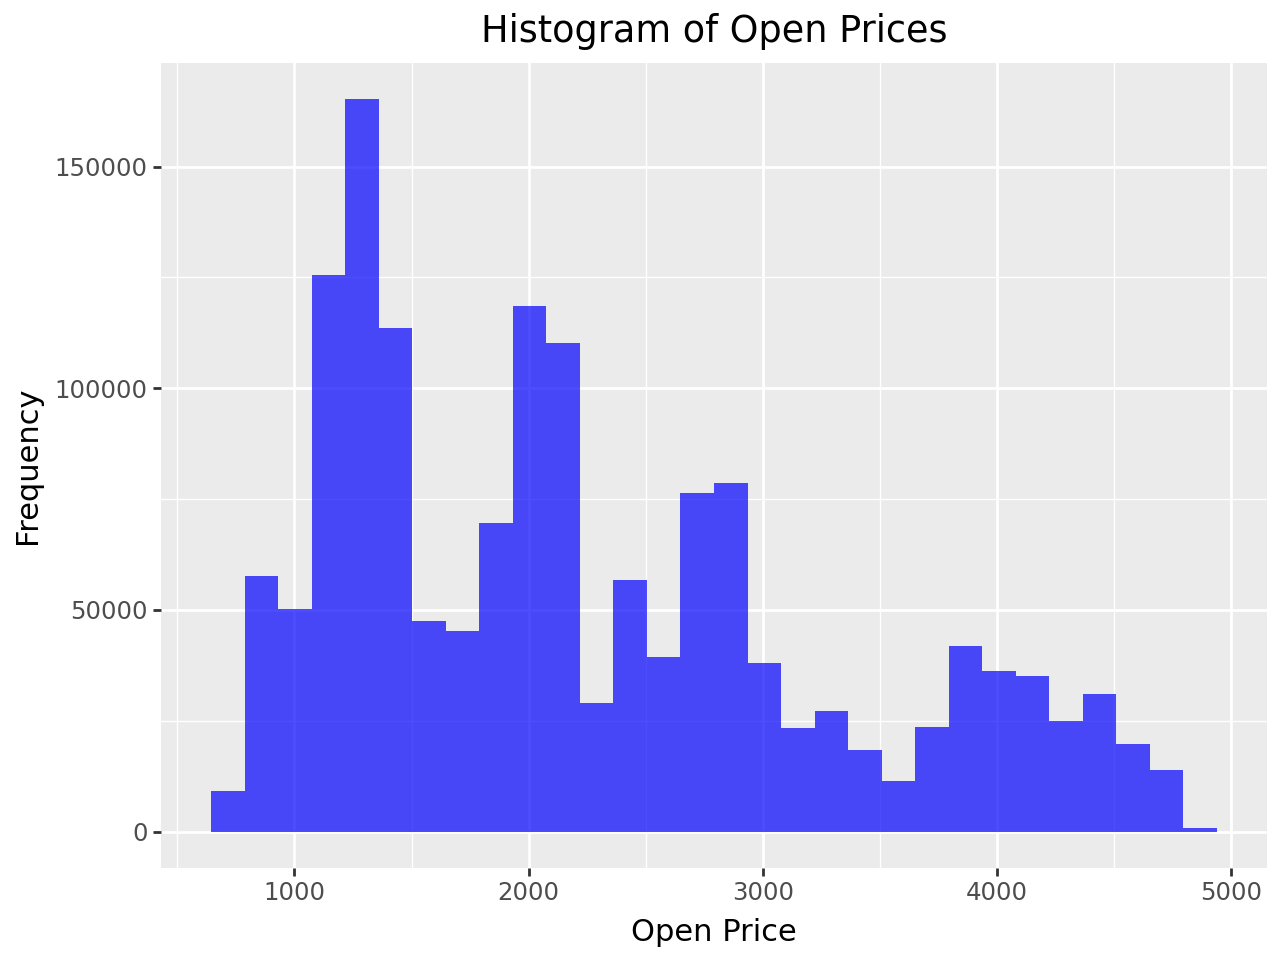

In [20]:
ggplot(spx_df, aes(x='open')) + geom_histogram(bins=30, fill='blue', alpha=0.7) + labs(title='Histogram of Open Prices', x='Open Price', y='Frequency')

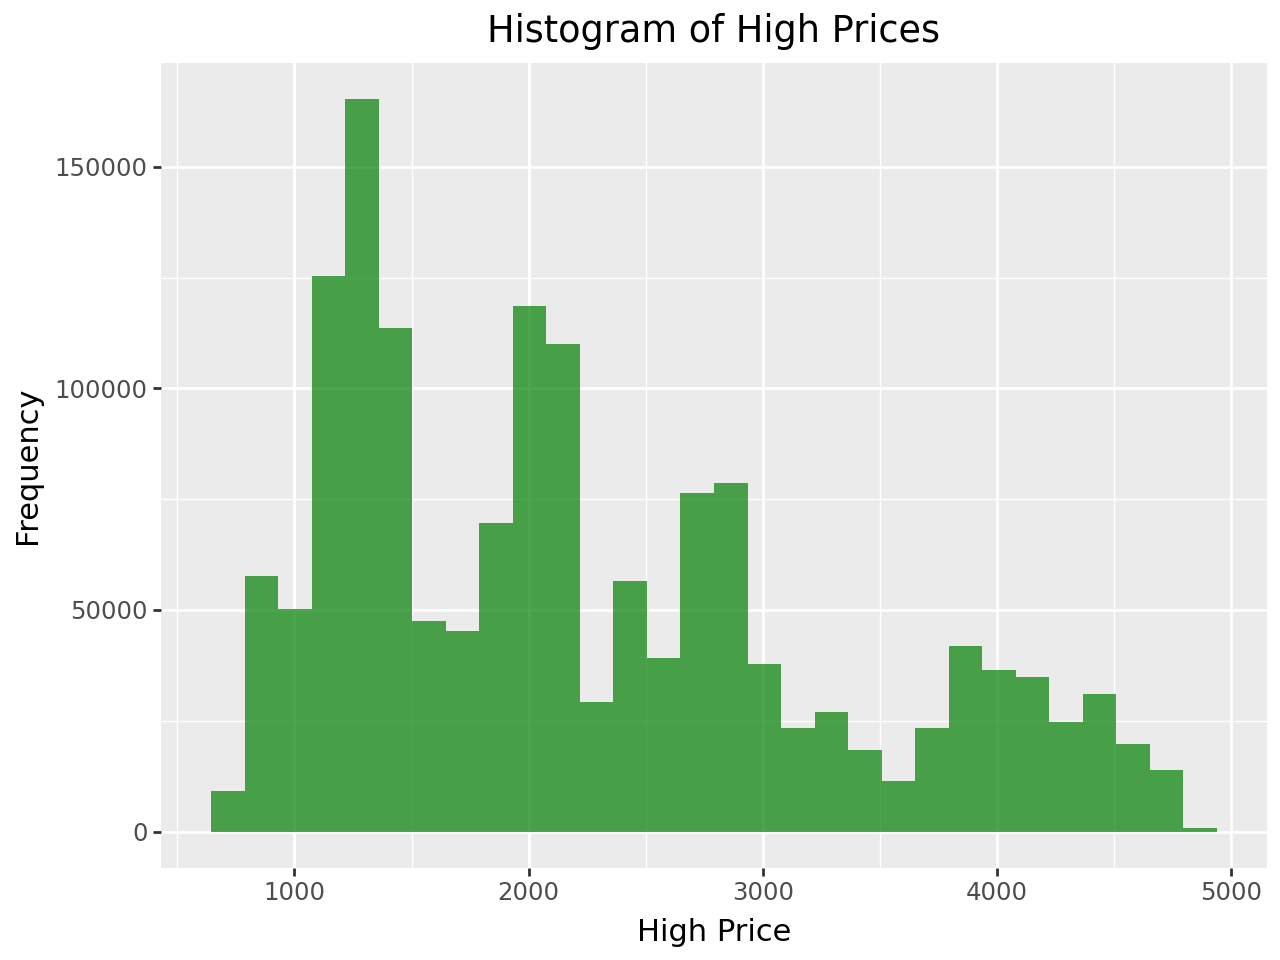

In [21]:
ggplot(spx_df, aes(x='high')) + geom_histogram(bins=30, fill='green', alpha=0.7) + labs(title='Histogram of High Prices', x='High Price', y='Frequency')

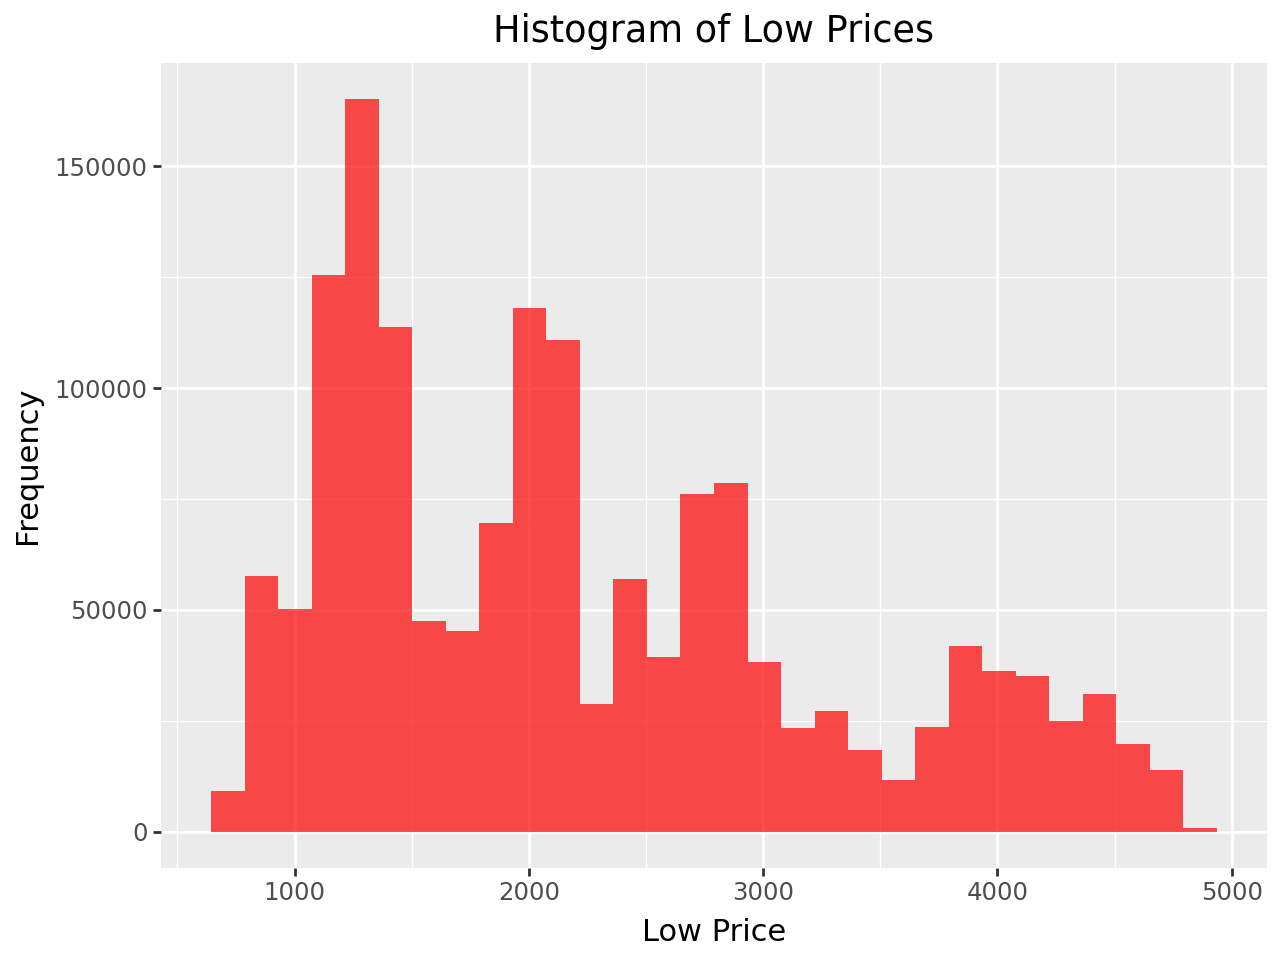

In [22]:
ggplot(spx_df, aes(x='low')) + geom_histogram(bins=30, fill='red', alpha=0.7) + labs(title='Histogram of Low Prices', x='Low Price', y='Frequency')

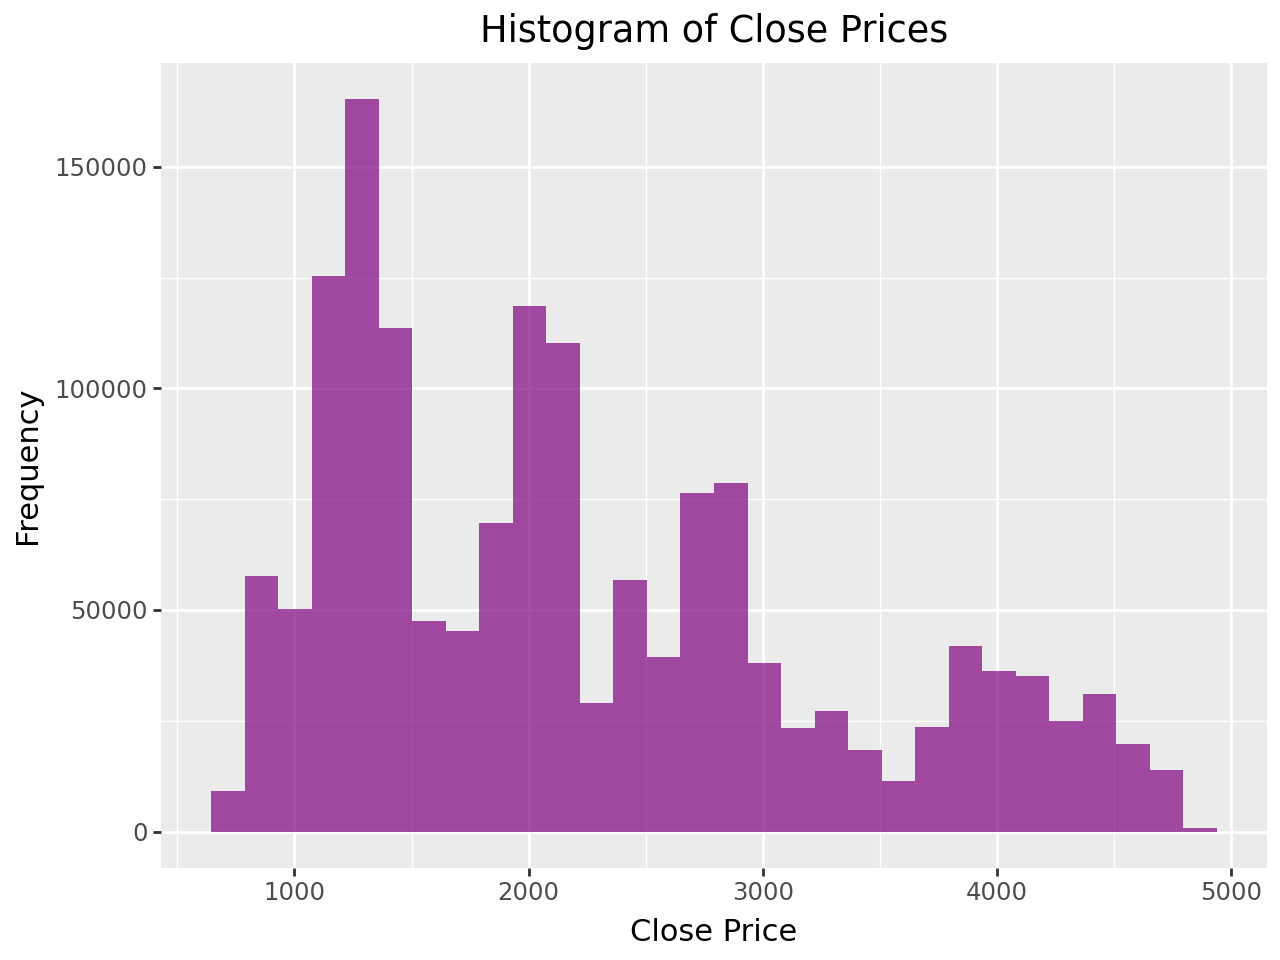

In [23]:
ggplot(spx_df, aes(x='close')) + geom_histogram(bins=30, fill='purple', alpha=0.7) + labs(title='Histogram of Close Prices', x='Close Price', y='Frequency')

# histogram of open, high, low, close - NDX

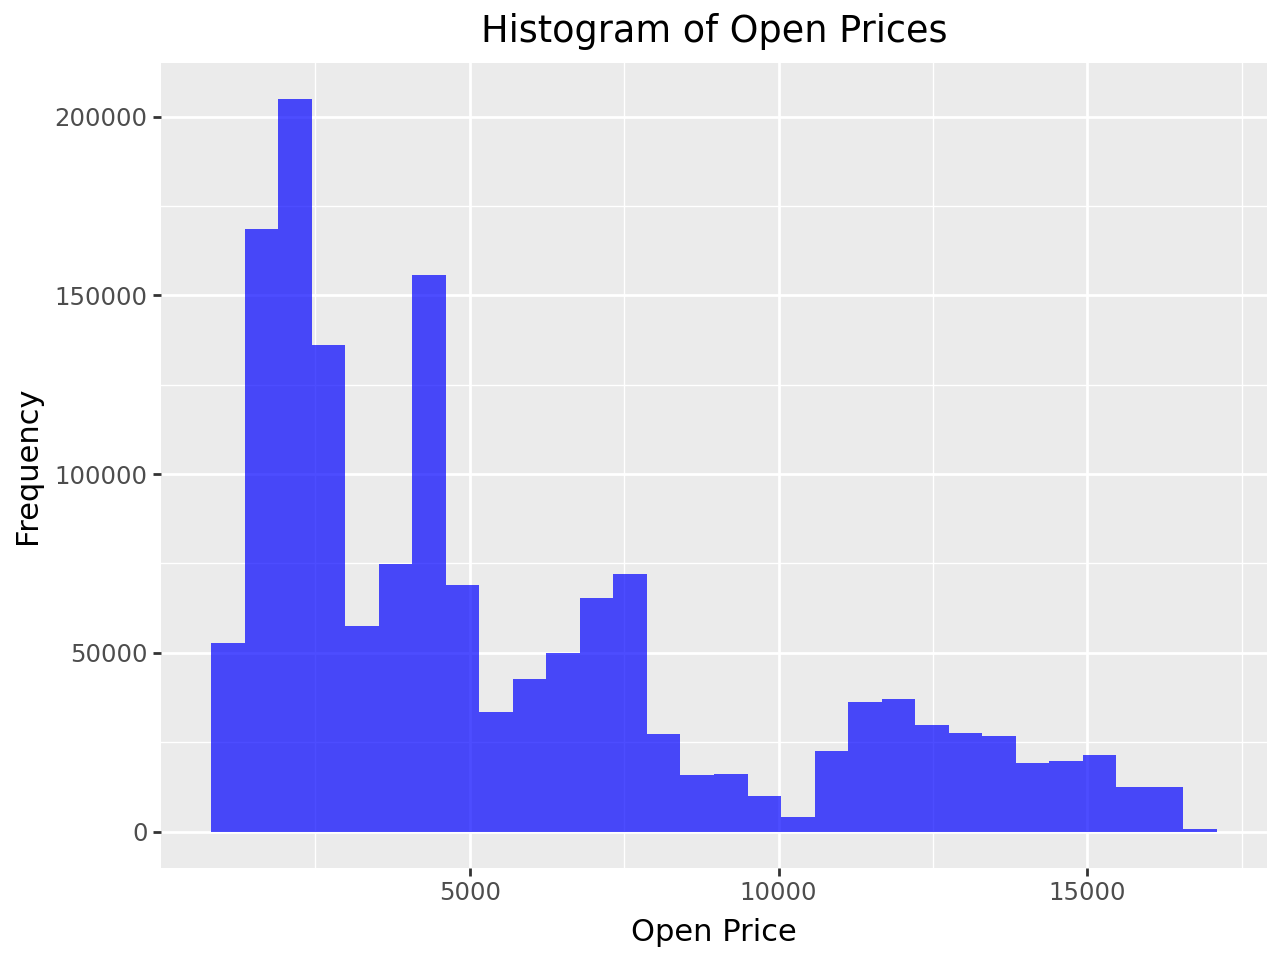

In [24]:
ggplot(ndx_df, aes(x='open')) + geom_histogram(bins=30, fill='blue', alpha=0.7) + labs(title='Histogram of Open Prices', x='Open Price', y='Frequency')

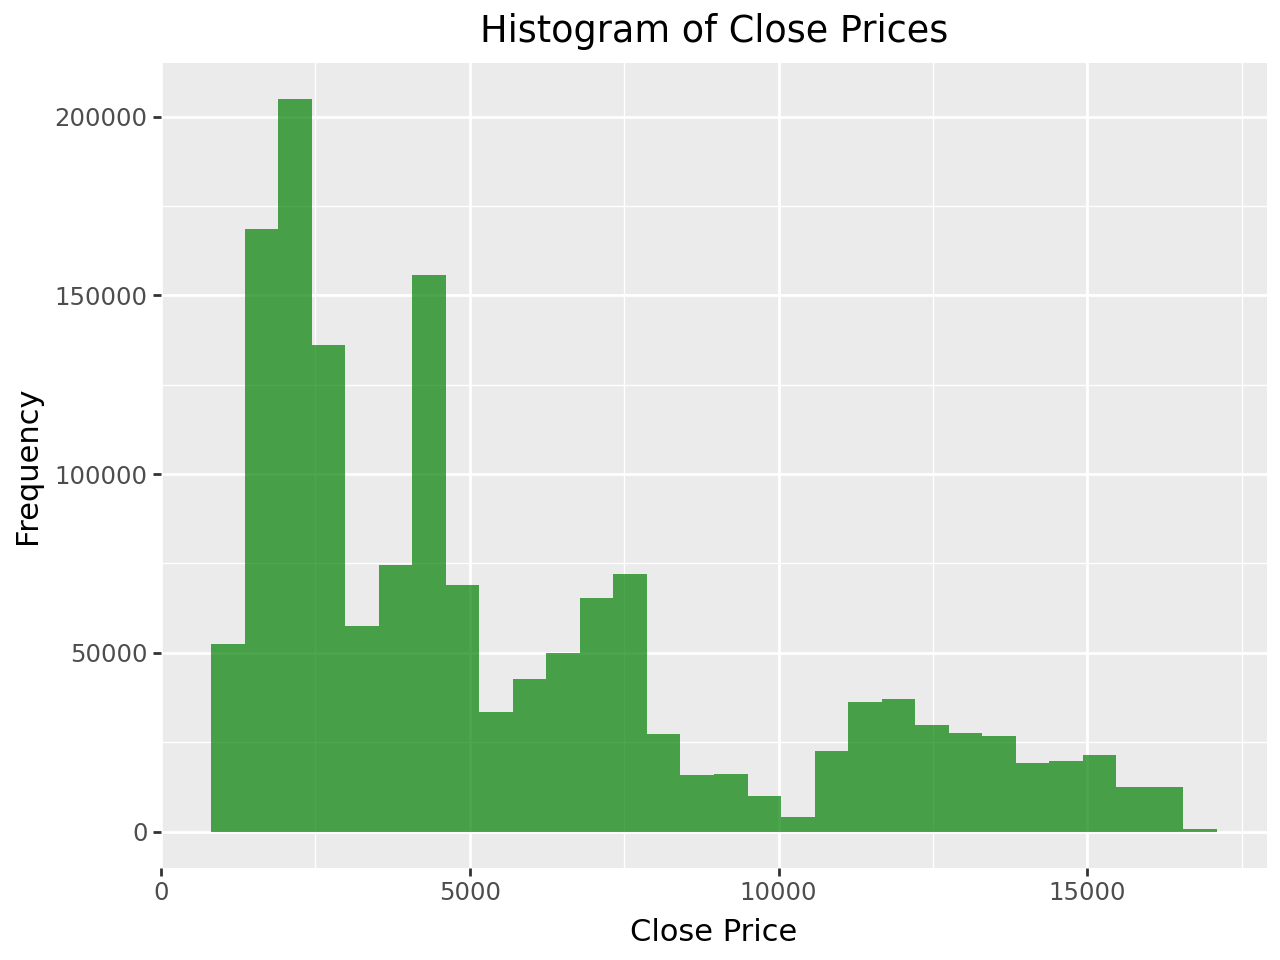

In [25]:
ggplot(ndx_df, aes(x='close')) + geom_histogram(bins=30, fill='green', alpha=0.7) + labs(title='Histogram of Close Prices', x='Close Price', y='Frequency')

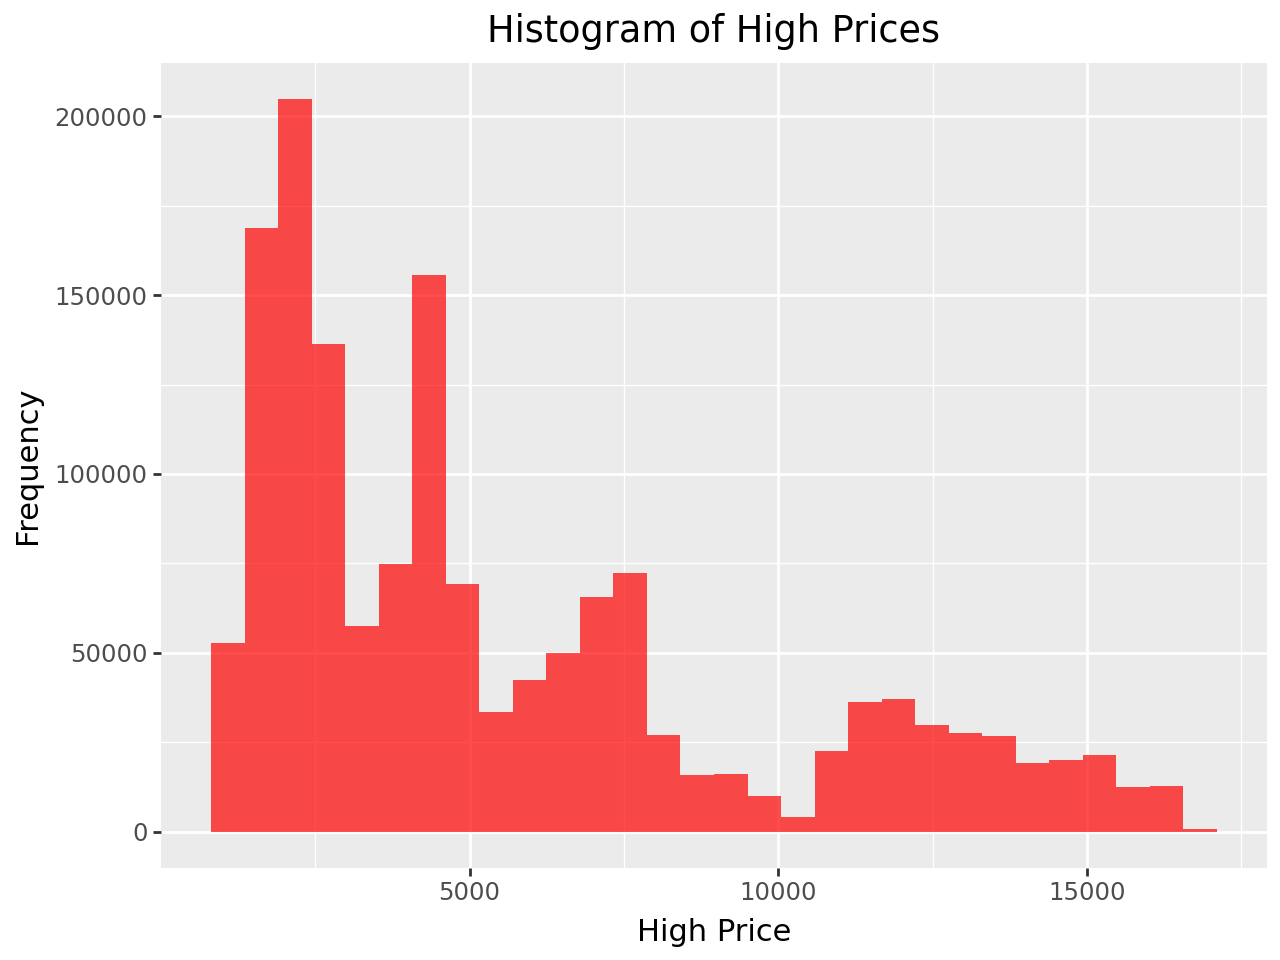

In [26]:
ggplot(ndx_df, aes(x='high')) + geom_histogram(bins=30, fill='red', alpha=0.7) + labs(title='Histogram of High Prices', x='High Price', y='Frequency')

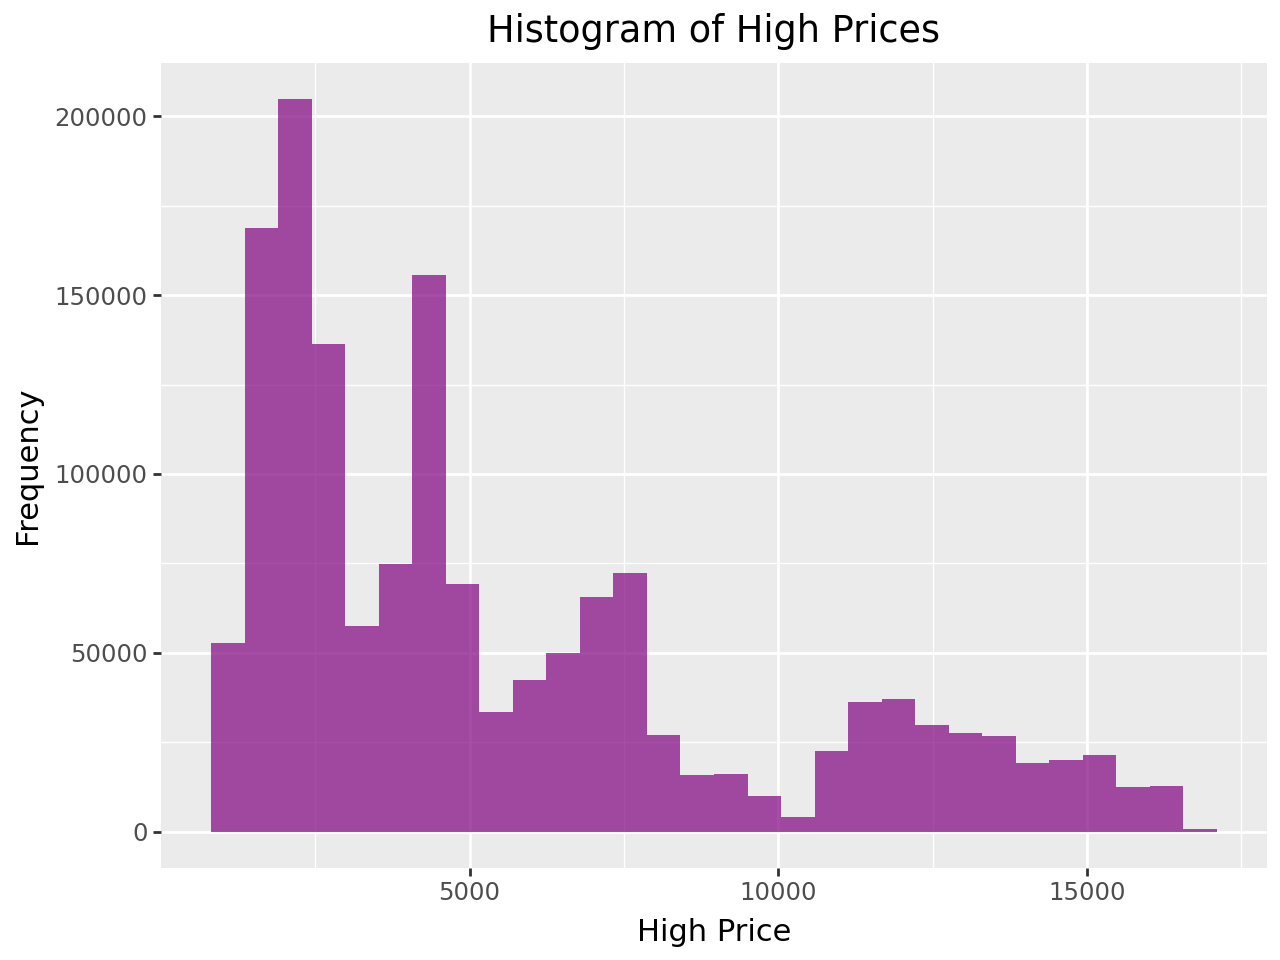

In [27]:
ggplot(ndx_df, aes(x='high')) + geom_histogram(bins=30, fill='purple', alpha=0.7) + labs(title='Histogram of High Prices', x='High Price', y='Frequency')

In [28]:
spx = spx_df.copy()

In [29]:
spx["datetime"] = pd.to_datetime(spx["tickerdate"] + " " + spx["tickertime"])
spx = spx.sort_values("datetime")

In [30]:
spx = spx.set_index("datetime")[["open","high","low","close"]]

In [31]:
SESSION_START = "09:30"
SESSION_END   = "16:00"

is_weekday = spx.index.weekday < 5
hhmm = spx.index.strftime("%H:%M")
in_session = (hhmm >= SESSION_START) & (hhmm <= SESSION_END)

spx = spx.loc[is_weekday & in_session].copy()

In [32]:
spx = spx.dropna().sort_index()

In [33]:
spx.head()

,open,high,low,close
datetime,,,,
2007-10-09 09:30:00,1553.18,1555.53,1553.18,1555.53
2007-10-09 09:31:00,1555.67,1556.19,1555.67,1556.04
2007-10-09 09:32:00,1555.80,1556.24,1555.80,1556.24
2007-10-09 09:33:00,1556.55,1556.55,1556.21,1556.21
2007-10-09 09:34:00,1555.78,1556.13,1555.58,1556.13


In [34]:
# filter only the last 5 years
end_dt = spx.index.max()
cutoff = end_dt - pd.DateOffset(years=5)
spx = spx.loc[spx.index >= cutoff].copy()

print("Date range:", spx.index.min(), "→", spx.index.max())
print("Rows after 5y filter:", len(spx))

Date range: 2018-03-26 09:30:00 → 2023-03-24 16:00:00
Rows after 5y filter: 490637


## Log Returns

In [35]:
spx["log_return"] = np.log(spx["close"] / spx["close"].shift(1))

In [36]:
# time features (cyclic encodings, as used in Informer/FEDformer-style setups)
spx["month"]   = spx.index.month
spx["weekday"] = spx.index.weekday
spx["hour"]    = spx.index.hour
spx["minute"]  = spx.index.minute

In [37]:
spx["month_sin"]   = np.sin(2*np.pi*spx["month"]/12)
spx["month_cos"]   = np.cos(2*np.pi*spx["month"]/12)
spx["weekday_sin"] = np.sin(2*np.pi*spx["weekday"]/7)
spx["weekday_cos"] = np.cos(2*np.pi*spx["weekday"]/7)
spx["hour_sin"]    = np.sin(2*np.pi*spx["hour"]/24)
spx["hour_cos"]    = np.cos(2*np.pi*spx["hour"]/24)
spx["minute_sin"]  = np.sin(2*np.pi*spx["minute"]/60)
spx["minute_cos"]  = np.cos(2*np.pi*spx["minute"]/60)

In [38]:
#drop the first NaN from log_return
spx = spx.dropna(subset=["log_return"]).copy()

### Features to be considered for the training

In [39]:
TIME_FEATS = [
    "month_sin","month_cos",
    "weekday_sin","weekday_cos",
    "hour_sin","hour_cos",
    "minute_sin","minute_cos"
]

In [40]:
# model will see past log_return + these time features
MODEL_FEATS = ["log_return"] + TIME_FEATS

In [41]:
spx.head()

,open,high,low,close,log_return,month,weekday,hour,minute,month_sin,month_cos,weekday_sin,weekday_cos,hour_sin,hour_cos,minute_sin,minute_cos
datetime,,,,,,,,,,,,,,,,,
2018-03-26 09:31:00,2629.65,2632.95,2628.95,2632.95,0.001254,3,0,9,31,1.0,6.123234e-17,0.0,1.0,0.707107,-0.707107,-0.104528,-0.994522
2018-03-26 09:32:00,2632.95,2633.30,2632.54,2632.91,-0.000015,3,0,9,32,1.0,6.123234e-17,0.0,1.0,0.707107,-0.707107,-0.207912,-0.978148
2018-03-26 09:33:00,2632.90,2633.39,2630.31,2630.64,-0.000863,3,0,9,33,1.0,6.123234e-17,0.0,1.0,0.707107,-0.707107,-0.309017,-0.951057
2018-03-26 09:34:00,2630.72,2633.25,2630.72,2632.78,0.000813,3,0,9,34,1.0,6.123234e-17,0.0,1.0,0.707107,-0.707107,-0.406737,-0.913545
2018-03-26 09:35:00,2632.89,2633.69,2630.64,2630.64,-0.000813,3,0,9,35,1.0,6.123234e-17,0.0,1.0,0.707107,-0.707107,-0.500000,-0.866025


In [42]:
from sklearn.preprocessing import StandardScaler

In [43]:
# sort te dataframe
spx = spx.sort_index()

In [44]:
# list unique trading days 
trading_days = np.array(sorted({ts.date() for ts in spx.index}))

In [45]:
# compute day-based boundaries
D = len(trading_days)
d_train_end = int(D * 0.70)
d_val_end   = int(D * 0.80)

In [46]:
# data split based on the day boundaries
train_days = trading_days[:d_train_end]
val_days   = trading_days[d_train_end:d_val_end]
test_days  = trading_days[d_val_end:]

In [47]:
# slice by full days (each split starts at that day’s first bar)
spx_train = spx[np.isin(spx.index.date, train_days)].copy()
spx_val   = spx[np.isin(spx.index.date, val_days)].copy()
spx_test  = spx[np.isin(spx.index.date, test_days)].copy()

In [48]:
# scale ONLY log_return using TRAIN statistics
scaler = StandardScaler().fit(spx_train[["log_return"]])
spx_train["log_return"] = scaler.transform(spx_train[["log_return"]])
spx_val["log_return"]   = scaler.transform(spx_val[["log_return"]])
spx_test["log_return"]  = scaler.transform(spx_test[["log_return"]])

In [49]:
X_train = spx_train[MODEL_FEATS].to_numpy(dtype="float32")
X_val   = spx_val  [MODEL_FEATS].to_numpy(dtype="float32")
X_test  = spx_test [MODEL_FEATS].to_numpy(dtype="float32")


In [50]:
# sanity check: first timestamps should be around 09:30 (or first available bar)
print("Train start:", spx_train.index.min())
print("Val   start:", spx_val.index.min())
print("Test  start:", spx_test.index.min())
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

Train start: 2018-03-26 09:31:00
Val   start: 2021-09-23 09:30:00
Test  start: 2022-03-24 09:30:00
Shapes: (343198, 9) (49107, 9) (98331, 9)


## Tin 720 Tout 336

In [51]:
# Choosing the context window
Tin  = 720
Tout = 336

def make_windows(arr: np.ndarray, Tin: int, Tout: int):
    X_enc, X_dec, Y = [], [], []
    T, D = arr.shape
    last_start = T - (Tin + Tout)
    if last_start <= 0:
        raise ValueError("Not enough rows for the chosen Tin/Tout.")

    for i in range(last_start):
        enc = arr[i:i+Tin]                 
        tgt = arr[i+Tin:i+Tin+Tout]         
        start = np.zeros((1, D), dtype=np.float32)
        dec_in = np.vstack([start, tgt[:-1]])
        X_enc.append(enc)
        X_dec.append(dec_in)
        Y.append(tgt)

    return (np.array(X_enc, dtype=np.float32),
            np.array(X_dec, dtype=np.float32),
            np.array(Y,     dtype=np.float32))

In [52]:
# build arrays from your 70:10:20 day-aligned splits
X_train_np = spx_train[MODEL_FEATS].to_numpy(dtype=np.float32)
X_val_np   = spx_val  [MODEL_FEATS].to_numpy(dtype=np.float32)
X_test_np  = spx_test [MODEL_FEATS].to_numpy(dtype=np.float32)

tr_enc, tr_dec, tr_tgt = make_windows(X_train_np, Tin, Tout)
va_enc, va_dec, va_tgt = make_windows(X_val_np,   Tin, Tout)
te_enc, te_dec, te_tgt = make_windows(X_test_np,  Tin, Tout)

print("Train windows:", tr_enc.shape, tr_dec.shape, tr_tgt.shape)
print("Val   windows:", va_enc.shape, va_dec.shape, va_tgt.shape)
print("Test  windows:", te_enc.shape, te_dec.shape, te_tgt.shape)

Train windows: (342142, 720, 9) (342142, 336, 9) (342142, 336, 9)
Val   windows: (48051, 720, 9) (48051, 336, 9) (48051, 336, 9)
Test  windows: (97275, 720, 9) (97275, 336, 9) (97275, 336, 9)


In [53]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [54]:
# convert numpy windows to PyTorch tensors
tr_enc_t  = torch.from_numpy(tr_enc)   
tr_dec_t  = torch.from_numpy(tr_dec)   
tr_tgt_t  = torch.from_numpy(tr_tgt)  

va_enc_t  = torch.from_numpy(va_enc)
va_dec_t  = torch.from_numpy(va_dec)
va_tgt_t  = torch.from_numpy(va_tgt)


In [55]:
# datasets
train_ds = TensorDataset(tr_enc_t, tr_dec_t, tr_tgt_t)
val_ds   = TensorDataset(va_enc_t, va_dec_t, va_tgt_t)


In [56]:
# loaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, drop_last=False)

In [57]:
import math
import torch.nn as nn

D = tr_enc.shape[2]   

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=4096, dropout=0.1):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)
    def forward(self, x):  # x: [S, B, E]
        return self.drop(x + self.pe[:x.size(0)].unsqueeze(1))

class TinyTransformer(nn.Module):
    def __init__(self, d_in, d_model=64, nhead=4, enc_layers=2, dec_layers=2, ff=128, dropout=0.1):
        super().__init__()
        self.inp = nn.Linear(d_in, d_model)
        self.pos = PositionalEncoding(d_model, dropout=dropout)
        self.tf  = nn.Transformer(
            d_model=d_model, nhead=nhead,
            num_encoder_layers=enc_layers, num_decoder_layers=dec_layers,
            dim_feedforward=ff, dropout=dropout, batch_first=False
        )
        self.out = nn.Linear(d_model, d_in)

    @staticmethod
    def tgt_mask(sz, device):
        m = torch.triu(torch.ones(sz, sz, device=device), diagonal=1).bool()
        return torch.zeros(sz, sz, device=device).masked_fill(m, float('-inf'))

    def forward(self, src, tgt):  # src: [Tin,B,D], tgt: [Tout,B,D]
        src = self.pos(self.inp(src))
        tgt = self.pos(self.inp(tgt))
        mask = self.tgt_mask(tgt.size(0), tgt.device)
        mem  = self.tf.encoder(src)
        dec  = self.tf.decoder(tgt, mem, tgt_mask=mask)
        return self.out(dec)  # [Tout,B,D]

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyTransformer(d_in=D).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

EPOCHS = 10  

for epoch in range(1, EPOCHS+1):
    # train
    model.train()
    train_loss, n_train = 0.0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d} [Train]", leave=False)
    for enc, dec_in, tgt in pbar:
        enc = enc.transpose(0,1).to(device)
        dec = dec_in.transpose(0,1).to(device)
        tgt = tgt.transpose(0,1).to(device)

        opt.zero_grad()
        out = model(enc, dec)
        loss = loss_fn(out, tgt)
        loss.backward()
        opt.step()

        train_loss += loss.item() * enc.size(1)
        n_train    += enc.size(1)
        pbar.set_postfix({"batch_loss": f"{loss.item():.6f}"})

    train_loss /= n_train

    # validate
    model.eval()
    val_loss, n_val = 0.0, 0
    pbar = tqdm(val_loader, desc=f"Epoch {epoch:02d} [Val]", leave=False)
    with torch.no_grad():
        for enc, dec_in, tgt in pbar:
            enc = enc.transpose(0,1).to(device)
            dec = dec_in.transpose(0,1).to(device)
            tgt = tgt.transpose(0,1).to(device)

            out = model(enc, dec)
            vloss = loss_fn(out, tgt)

            val_loss += vloss.item() * enc.size(1)
            n_val    += enc.size(1)
            pbar.set_postfix({"batch_loss": f"{vloss.item():.6f}"})

    val_loss /= n_val
    print(f"Epoch {epoch:02d} | train MSE={train_loss:.6f} | val MSE={val_loss:.6f}")

/home/fti_ncchethala/.local/lib/python3.9/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)


Epoch 01 [Train]:   0%|          | 0/5345 [00:00<?, ?it/s]

Epoch 01 [Val]:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 01 | train MSE=0.117460 | val MSE=0.086201


Epoch 02 [Train]:   0%|          | 0/5345 [00:00<?, ?it/s]

Epoch 02 [Val]:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 02 | train MSE=0.105234 | val MSE=0.100164


Epoch 03 [Train]:   0%|          | 0/5345 [00:00<?, ?it/s]

Epoch 03 [Val]:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 03 | train MSE=0.092944 | val MSE=0.088771


Epoch 04 [Train]:   0%|          | 0/5345 [00:00<?, ?it/s]

Epoch 04 [Val]:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 04 | train MSE=0.086686 | val MSE=0.104266


Epoch 05 [Train]:   0%|          | 0/5345 [00:00<?, ?it/s]

Epoch 05 [Val]:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 05 | train MSE=0.087633 | val MSE=0.100686


Epoch 06 [Train]:   0%|          | 0/5345 [00:00<?, ?it/s]

Epoch 06 [Val]:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 06 | train MSE=0.081951 | val MSE=0.096340


Epoch 07 [Train]:   0%|          | 0/5345 [00:00<?, ?it/s]

Epoch 07 [Val]:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 07 | train MSE=0.079442 | val MSE=0.108318


Epoch 08 [Train]:   0%|          | 0/5345 [00:00<?, ?it/s]

Epoch 08 [Val]:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 08 | train MSE=0.077826 | val MSE=0.130727


Epoch 09 [Train]:   0%|          | 0/5345 [00:00<?, ?it/s]

Epoch 09 [Val]:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 09 | train MSE=0.077829 | val MSE=0.105704


Epoch 10 [Train]:   0%|          | 0/5345 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 10 | train MSE=0.072637 | val MSE=0.127245


In [59]:
torch.save(model.state_dict(), "../vanilla_transformer_720_336.pth")

In [60]:
import joblib
joblib.dump(scaler, "scaler_log_return_720.joblib")

['scaler_log_return_720.joblib']

In [61]:
scaler = joblib.load("scaler_log_return_720.joblib")

In [62]:
print(f"Number of test samples: {len(te_enc)}")

# Check one sample
sample_enc = te_enc[0]
sample_tgt = te_tgt[0]

print(f"Encoder input shape (Tin, D): {sample_enc.shape}")
print(f"Target output shape (Tout, D): {sample_tgt.shape}")

Tin = sample_enc.shape[0]
Tout = sample_tgt.shape[0]

print(f"\n✅ Verified Tin = {Tin}, Tout = {Tout}")

Number of test samples: 97275
Encoder input shape (Tin, D): (720, 9)
Target output shape (Tout, D): (336, 9)

✅ Verified Tin = 720, Tout = 336


In [63]:
# @torch.no_grad()
# def forecast_next(model, arr_tail, steps, device):
#     """
#     arr_tail: np.array of shape [Tin, D] (normalized features)
#     steps:    Tout
#     returns:  np.array of shape [Tout, D] (normalized predictions)
#     """
#     model.eval()
#     x = torch.from_numpy(arr_tail.astype(np.float32)).unsqueeze(1).to(device)  
#     start = torch.zeros(1, 1, arr_tail.shape[1], device=device)                
#     # encode once
#     mem = model.tf.encoder(model.pos(model.inp(x)))
#     dec_in = start
#     preds = []
#     for _ in range(steps):
#         de  = model.pos(model.inp(dec_in))
#         m   = model.tgt_mask(de.size(0), de.device)
#         out = model.tf.decoder(de, mem, tgt_mask=m)
#         y   = model.out(out[-1:])  # [1,1,D]
#         preds.append(y)
#         dec_in = torch.cat([dec_in, y], dim=0)
#     return torch.cat(preds, dim=0).squeeze(1).cpu().numpy() 

@torch.no_grad()
def forecast_next_batch(model, arr_batch, steps, device):
    """
    arr_batch: np.array [batch_size, Tin, D] (normalized features)
    steps:     int (Tout)
    returns:   torch.Tensor [batch_size, Tout, D] (on GPU)
    """
    model.eval()
    B, Tin, D = arr_batch.shape

    # [Tin, B, D] → sequence-first for transformer
    x = torch.from_numpy(arr_batch.astype(np.float32)).permute(1, 0, 2).to(device)

    # Encode once for all batch sequences
    mem = model.module.tf.encoder(model.module.pos(model.module.inp(x))) \
          if isinstance(model, torch.nn.DataParallel) else \
          model.tf.encoder(model.pos(model.inp(x)))

    # Initialize decoder inputs
    dec_in = torch.zeros(1, B, D, device=device)
    preds = []

    for _ in range(steps):
        if isinstance(model, torch.nn.DataParallel):
            de = model.module.pos(model.module.inp(dec_in))
            m  = model.module.tgt_mask(de.size(0), de.device)
            out = model.module.tf.decoder(de, mem, tgt_mask=m)
            y   = model.module.out(out[-1:])  # [1, B, D]
        else:
            de = model.pos(model.inp(dec_in))
            m  = model.tgt_mask(de.size(0), de.device)
            out = model.tf.decoder(de, mem, tgt_mask=m)
            y   = model.out(out[-1:])

        preds.append(y)
        dec_in = torch.cat([dec_in, y], dim=0)

    preds = torch.cat(preds, dim=0).permute(1, 0, 2)  # [B, Tout, D]
    return preds

In [64]:
# def directional_accuracy(y_true, y_pred, col=0):
#     return float((np.sign(y_true[:, col]) == np.sign(y_pred[:, col])).mean())

# mse_list, mae_list, da_list = [], [], []

# for i in range(len(te_enc)):
#     yhat = forecast_next(model, te_enc[i], steps=Tout, device=device) 
#     ytrue = te_tgt[i]                                                 
#     mse = np.mean((ytrue - yhat)**2)
#     mae = np.mean(np.abs(ytrue - yhat))
#     da  = directional_accuracy(ytrue, yhat, col=0) 
#     mse_list.append(mse); mae_list.append(mae); da_list.append(da)

# print(f"Test MSE (avg): {np.mean(mse_list):.6f}")
# print(f"Test MAE (avg): {np.mean(mae_list):.6f}")
# print(f"Directional Accuracy on log_return (avg): {np.mean(da_list):.3f}")
@torch.no_grad()
def evaluate_model_batched(model, te_enc, te_tgt, Tout, device, batch_size=32):
    model.eval()
    mse_list, mae_list, da_list = [], [], []

    num_samples = len(te_enc)
    num_batches = int(np.ceil(num_samples / batch_size))
    pbar = tqdm(range(num_batches), desc="Evaluating in batches")

    for b in pbar:
        start = b * batch_size
        end = min((b + 1) * batch_size, num_samples)

        # Stack batch
        enc_batch = np.stack(te_enc[start:end])  # [B, Tin, D]
        tgt_batch = np.stack(te_tgt[start:end])  # [B, Tout, D]

        # GPU tensors
        ytrue = torch.from_numpy(tgt_batch.astype(np.float32)).to(device)
        yhat  = forecast_next_batch(model, enc_batch, steps=Tout, device=device)

        # Compute metrics (each sample)
        mse = torch.mean((ytrue - yhat) ** 2, dim=(1, 2))
        mae = torch.mean(torch.abs(ytrue - yhat), dim=(1, 2))

        # Directional Accuracy per sample
        da_tensor = (torch.sign(ytrue[..., 0]) == torch.sign(yhat[..., 0])).float()
        da = da_tensor.mean(dim=1)  # mean across time per sample → shape [B]

        # Append safely
        mse_list.extend(mse.cpu().numpy().tolist())
        mae_list.extend(mae.cpu().numpy().tolist())
        da_list.extend(da.cpu().numpy().tolist())

        # Live progress bar
        pbar.set_postfix({
            "MSE": f"{np.mean(mse_list):.6f}",
            "MAE": f"{np.mean(mae_list):.6f}",
            "DA":  f"{np.mean(da_list):.3f}"
        })

        torch.cuda.empty_cache()

    print("\n✅ Batched Evaluation complete:")
    print(f"Test MSE (avg): {np.mean(mse_list):.6f}")
    print(f"Test MAE (avg): {np.mean(mae_list):.6f}")
    print(f"Directional Accuracy (avg): {np.mean(da_list):.3f}")

In [65]:
evaluate_model_batched(model, te_enc, te_tgt, Tout, device, batch_size=32)

Evaluating in batches:   0%|          | 0/3040 [00:00<?, ?it/s]


✅ Batched Evaluation complete:
Test MSE (avg): 0.393512
Test MAE (avg): 0.368307
Directional Accuracy (avg): 0.500


In [66]:
# pick one test window to inspect
yhat_norm = forecast_next(model, te_enc[0], steps=Tout, device=device)
ytrue_norm = te_tgt[0]

# invert scaling for the log_return column (col 0)
def invert_log_return_scaling(norm_seq_col0, scaler):
    return scaler.inverse_transform(norm_seq_col0.reshape(-1,1)).reshape(-1)

yhat_logret = invert_log_return_scaling(yhat_norm[:,0], scaler)
ytrue_logret = invert_log_return_scaling(ytrue_norm[:,0], scaler)

# reconstruct prices from the last known close before this window
last_known_close = spx_test["close"].iloc[Tin-1]  # aligned with your windowing
pred_prices = [last_known_close]
for r in yhat_logret:
    pred_prices.append(pred_prices[-1] * np.exp(r))
pred_prices = np.array(pred_prices[1:])  # length == Tout

NameError: name 'forecast_next' is not defined

In [ ]:
import joblib
torch.save(model.state_dict(), "vanilla_transformer_spx.pt")
joblib.dump(scaler, "scaler_log_return.joblib")
np.savez("config_windows.npz", Tin=Tin, Tout=Tout, D=D)

# With Tin 336 and Tout 48

In [ ]:
# # ==================================================
# # Setup: Detect and use all available GPUs
# # ==================================================
# if torch.cuda.is_available():
#     n_gpus = torch.cuda.device_count()
#     print(f"✅ {n_gpus} GPUs detected:")
#     for i in range(n_gpus):
#         print(f"   GPU {i}: {torch.cuda.get_device_name(i)}")
# else:
#     raise SystemError("❌ No CUDA devices available")

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # ==================================================
# # Model setup — wrap in DataParallel for multi-GPU
# # ==================================================
# model = TinyTransformer(d_in=D)

# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model)  # split batches automatically
#     print("✅ Using DataParallel for multi-GPU training")

# model = model.to(device)

# # ==================================================
# # Optimizer, loss, mixed precision setup
# # ==================================================
# opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
# loss_fn = nn.MSELoss()
# scaler = GradScaler()  # AMP scaler

# torch.backends.cudnn.benchmark = True
# torch.set_float32_matmul_precision("high")

# # ==================================================
# # Training loop
# # ==================================================
# EPOCHS = 10

# for epoch in range(1, EPOCHS + 1):
#     # ------------------ TRAIN ------------------
#     model.train()
#     train_loss, n_train = 0.0, 0

#     pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d} [Train]", leave=False)

#     for enc, dec_in, tgt in pbar:
#         enc = enc.transpose(0, 1).to(device, non_blocking=True)
#         dec = dec_in.transpose(0, 1).to(device, non_blocking=True)
#         tgt = tgt.transpose(0, 1).to(device, non_blocking=True)

#         opt.zero_grad(set_to_none=True)

#         # mixed precision for performance
#         with autocast():
#             out = model(enc, dec)
#             loss = loss_fn(out, tgt)

#         scaler.scale(loss).backward()
#         scaler.step(opt)
#         scaler.update()

#         train_loss += loss.item() * enc.size(1)
#         n_train += enc.size(1)
#         pbar.set_postfix({"batch_loss": f"{loss.item():.6f}"})

#         # free memory
#         del enc, dec, tgt, out, loss
#         torch.cuda.empty_cache()

#     train_loss /= n_train

#     # ------------------ VALIDATION ------------------
#     model.eval()
#     val_loss, n_val = 0.0, 0
#     pbar = tqdm(val_loader, desc=f"Epoch {epoch:02d} [Val]", leave=False)

#     with torch.inference_mode(), autocast():
#         for enc, dec_in, tgt in pbar:
#             enc = enc.transpose(0, 1).to(device, non_blocking=True)
#             dec = dec_in.transpose(0, 1).to(device, non_blocking=True)
#             tgt = tgt.transpose(0, 1).to(device, non_blocking=True)

#             out = model(enc, dec)
#             vloss = loss_fn(out, tgt)

#             val_loss += vloss.item() * enc.size(1)
#             n_val += enc.size(1)
#             pbar.set_postfix({"batch_loss": f"{vloss.item():.6f}"})

#             del enc, dec, tgt, out, vloss
#             torch.cuda.empty_cache()

#     val_loss /= n_val
#     print(f"Epoch {epoch:02d} | train MSE={train_loss:.6f} | val MSE={val_loss:.6f}")